In [11]:
import scipy
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [12]:
from ppg.common import config
from ppg.common.utils import load_data
from ppg.enums import DataColumn, WavelengthIndex

In [13]:
ts1 = load_data('ppg_curve_0.nc')
ts2 = load_data('ppg_curve_1.nc')

In [14]:
# sampling frequency
Fs = 100
Tstep = 1 / Fs

# number of samples
N = len(ts1[DataColumn.TIME])
Fstep = Fs / N

FILTER_ORDER = 5

In [15]:
ts1[DataColumn.WAVELENGTH][:], ts2[DataColumn.WAVELENGTH][:]

(array(['pleth', 'red', 'ir'], dtype=object),
 array(['pleth', 'red', 'ir'], dtype=object))

In [16]:
# According to metadata, ts2 was captured before ts1. Merging solution should be order independent and robust

In [17]:
TS1_DURATION = max(ts1[DataColumn.TIME][:])
TS2_DURATION = max(ts2[DataColumn.TIME][:])

TS1_DURATION, TS2_DURATION

(123.32000000000001, 122.31)

In [18]:
TS1_BEGIN = datetime.fromisoformat(ts1[DataColumn.PPG_CURVE].meas_datetime)
TS2_BEGIN = datetime.fromisoformat(ts2[DataColumn.PPG_CURVE].meas_datetime)

In [19]:
GAP_DURATION = (TS1_BEGIN - TS2_BEGIN - timedelta(seconds=TS2_DURATION)).seconds

In [20]:
from ppg.processing.normalization import ZscoreNormalization
from ppg.processing.filter import BandPassPaddingFilter
from ppg.processing.missing_values import PolynomialInterpolation
from ppg.processing import Pipeline

pipeline = Pipeline([
    PolynomialInterpolation(),
    ZscoreNormalization(),
    BandPassPaddingFilter(order=config.DEFAULT_FILTER_ORDER,
                          sampling_frequency=Fs,
                          cutoff_frequencies=(0.1, 5),
                          padding_size=Fs * config.FILTER_PADDING_MULTIPLIER),

])

In [21]:
ts1_data = pipeline.process(ts1[DataColumn.PPG_CURVE][:])[:, -9000:]
ts2_data = pipeline.process(ts2[DataColumn.PPG_CURVE][:])[:, :9000]

# ts1_data = ts1_data[:]

data_before_gap = ts1_data[WavelengthIndex.RED]
data_after_gap = ts2_data[WavelengthIndex.RED]

gap_data = np.empty((3, GAP_DURATION * Fs))
gap_data[:] = np.nan

In [22]:
ts1_data.shape, ts2_data.shape

((3, 9000), (3, 9000))

In [23]:
ppg_data = np.concatenate((ts1_data, gap_data, ts2_data), axis=1)

time_steps = np.arange(0, ppg_data.shape[1]/Fs, 1/Fs)

In [24]:
pd.DataFrame(ppg_data).to_parquet('../../data/ext.parquet')

ValueError: parquet must have string column names

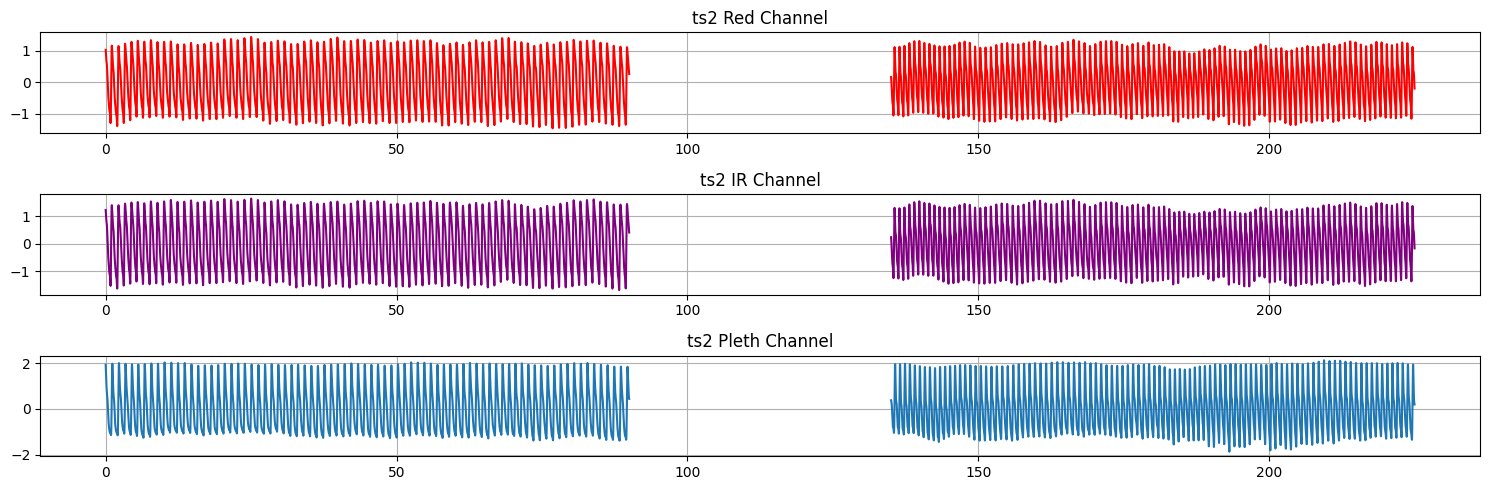

In [25]:
plt.figure(figsize=(15,5))

plt.subplot(3,1,1)
plt.plot(time_steps, ppg_data[WavelengthIndex.RED], color='red')
plt.title('ts2 Red Channel')
plt.grid()

plt.subplot(3,1,2)
plt.plot(time_steps, ppg_data[WavelengthIndex.IR], color='purple')
plt.title('ts2 IR Channel')
plt.grid()

plt.subplot(3,1,3)
plt.plot(time_steps, ppg_data[WavelengthIndex.PLETH])
plt.title('ts2 Pleth Channel')

plt.tight_layout()
plt.grid()
plt.show()

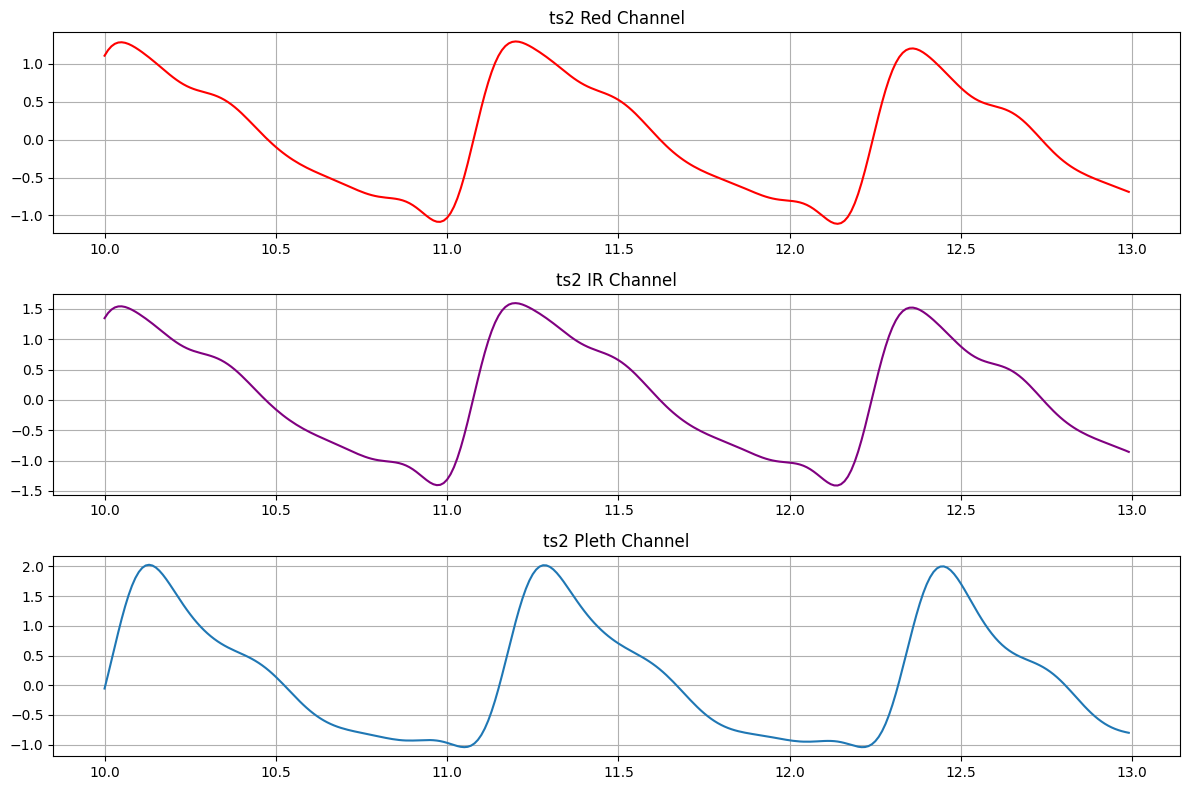

In [26]:
plt.figure(figsize=(12,8))

START = 1000
END = 1300

plt.subplot(3,1,1)
plt.plot(time_steps[START:END], ppg_data[WavelengthIndex.RED][START:END], color='red')
plt.title('ts2 Red Channel')
plt.grid()

plt.subplot(3,1,2)
plt.plot(time_steps[START:END], ppg_data[WavelengthIndex.IR][START:END], color='purple')
plt.title('ts2 IR Channel')
plt.grid()

plt.subplot(3,1,3)
plt.plot(time_steps[START:END], ppg_data[WavelengthIndex.PLETH][START:END])
plt.title('ts2 Pleth Channel')

plt.tight_layout()
plt.grid()
plt.show()

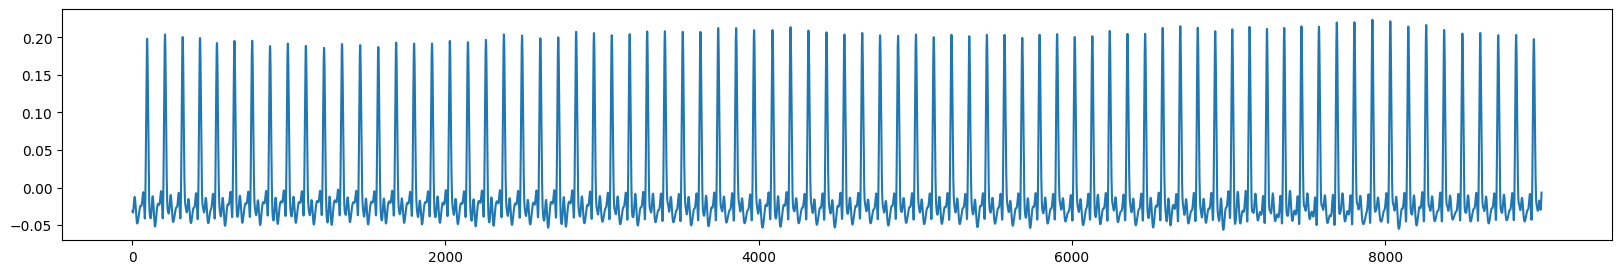

In [27]:
plt.figure(figsize=(20,3))
plt.plot(pd.DataFrame(ts1_data[WavelengthIndex.RED]).diff())

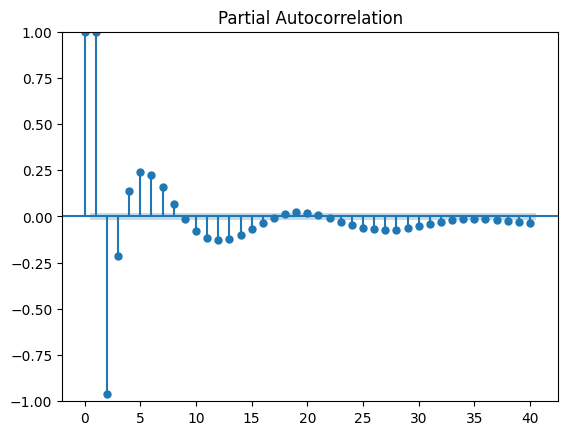

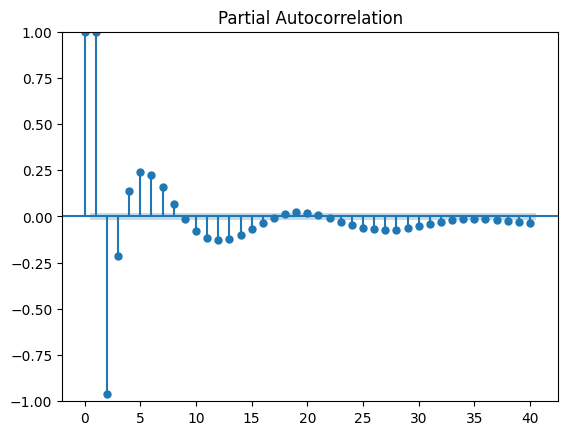

In [28]:
import pandas  as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(pd.DataFrame(pd.DataFrame(ts1_data[WavelengthIndex.RED])))

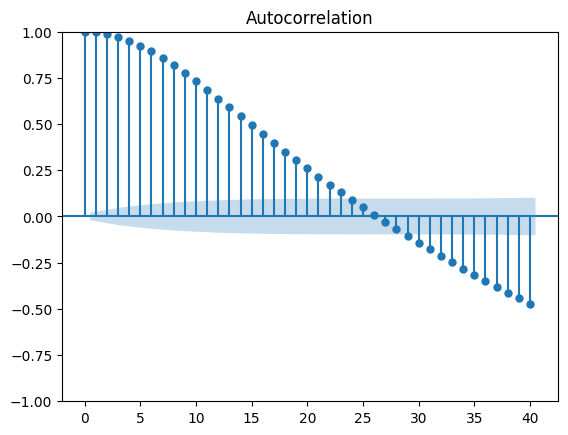

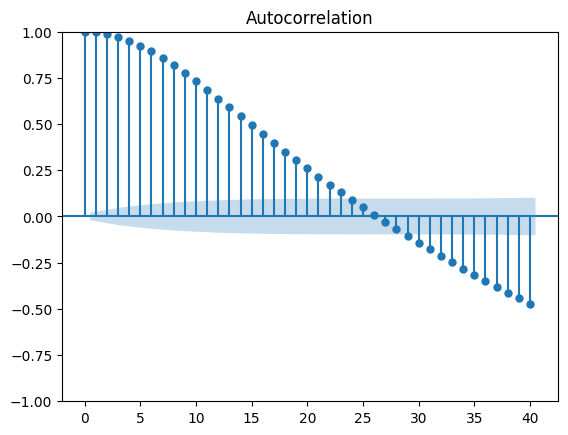

In [29]:
plot_acf(ts1_data[WavelengthIndex.RED])

In [19]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

check_stationarity(ts1_data[WavelengthIndex.RED])

ADF Statistic: -39.869617
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [30]:
data = ppg_data[WavelengthIndex.RED]

gap_indices = np.argwhere(np.isnan(data))
gap_start = gap_indices.min()
gap_end = gap_indices.max()

In [31]:
df = pd.DataFrame({'value': ppg_data[WavelengthIndex.RED]})

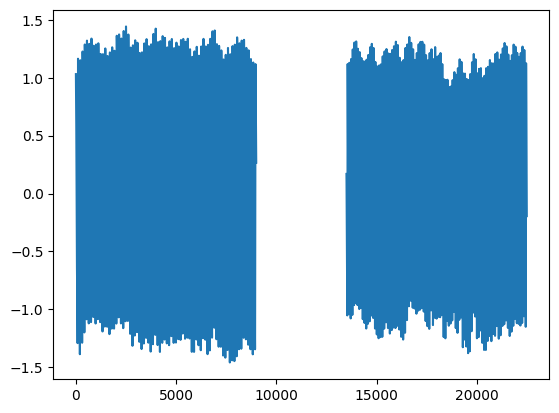

In [32]:
plt.plot(df)

In [24]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

data_before_gap = df.loc[df.index < gap_start, 'value']
data_after_gap = df.loc[df.index > gap_end, 'value']

train_data = pd.concat([data_before_gap, data_after_gap])
model = SARIMAX(train_data, order=(10, 4, 10))
model_fit = model.fit()

gap_predictions = model_fit.predict(start=gap_start, end=gap_end)
final_data = pd.concat([data_before_gap, gap_predictions, data_after_gap])

C:\Users\oliver.holly.HQ\Projects\seerlinq\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\oliver.holly.HQ\Projects\seerlinq\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


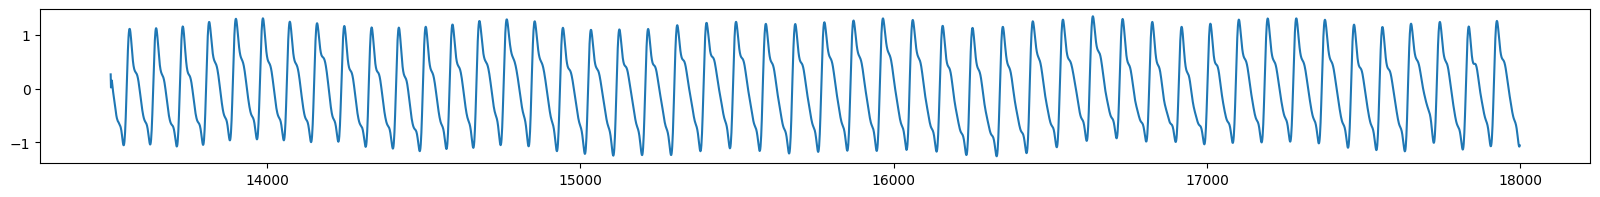

In [22]:
plt.figure(figsize=(20,2))
plt.plot(gap_predictions)

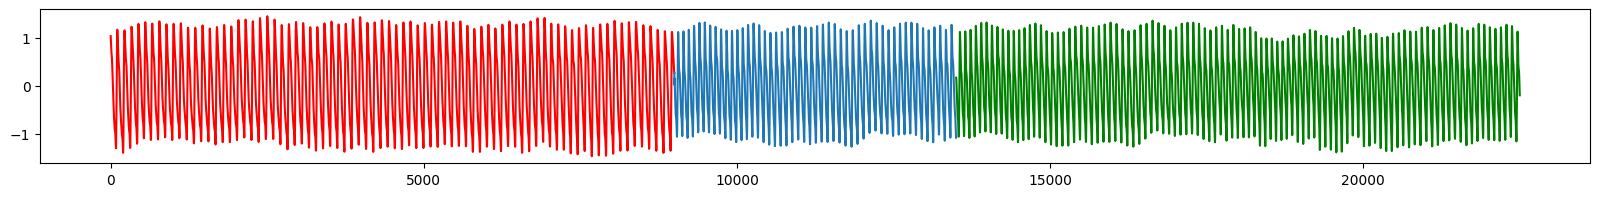

In [23]:
plt.figure(figsize=(20,2))
plt.plot(np.arange(0, gap_start,1),data_before_gap, color='red')
plt.plot(np.arange(gap_start,gap_end+1), gap_predictions)
plt.plot(np.arange(gap_end, gap_end+len(ts2_data[0])), data_after_gap, color='green')

In [20]:
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import tensorflow as tf

In [23]:


sequence_length = len(data)
feature_dim = 1

inputs = keras.layers.Input(shape=(sequence_length, feature_dim))

x = keras.layers.LSTM(16, return_sequences=False)(inputs)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.RepeatVector(sequence_length)(x)

x = keras.layers.LSTM(16, return_sequences=True)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1)(x)

model = keras.Model(inputs, x)
model.compile(loss='mae', optimizer='adam')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10000, 1)]        0         
                                                                 
 lstm (LSTM)                 (None, 16)                1152      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 10000, 16)        0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 10000, 16)         2112      
                                                                 
 dropout_1 (Dropout)         (None, 10000, 16)         0         
                                                             

In [25]:
def generate_shrinking_masked_window(data, steps: int):
    """
    """
    gap_indices = np.argwhere(np.isnan(data))

    left_indices = np.arange(0, gap_indices.min(), 1)
    right_indices = np.arange(gap_indices.max() + 1, len(data), 1)

    while True:
        for i in range(steps):
            left_window_size = (len(left_indices) // steps) * (steps - i)
            right_window_size = (len(right_indices) // steps) * (steps - i)

            # Mask of indices which are supposed to be reconstructed
            mask_indices = np.concatenate([left_indices[-left_window_size:], right_indices[-right_window_size:]])

            sample_weights = np.zeros(len(data))
            np.put(sample_weights, mask_indices, 1.0)

            yield data.reshape(-1,1), data.reshape(-1,1), sample_weights

train_generator = generate_shrinking_masked_window(data, 6)

In [26]:
train_data = next(train_generator)

In [30]:
tf.config.run_functions_eagerly(True)

In [ ]:
model.fit(train_data[0], train_data[1], sample_weight=train_data[2], steps_per_epoch=1, epochs=1)

C:\Users\oliver.holly.HQ\Projects\seerlinq\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
model

In [224]:
import numpy as np
import scipy.signal
import scipy.fftpack
from scipy.interpolate import interp1d

# Parameters
window_len = 1000  # length of the windows to split the time series into
overlap_len = 500  # overlap between windows

# Function to split the time series into windows
def sliding_window(ts, window_len, overlap_len):
    step = window_len - overlap_len
    windows = [ts[i: i+window_len] for i in range(0, len(ts)-window_len+1, step)]
    return np.array(windows)

# Split the time series into windows
windows1 = sliding_window(ts1_data[WavelengthIndex.RED], window_len, overlap_len)
windows2 = sliding_window(ts2_data[WavelengthIndex.RED], window_len, overlap_len)

# Compute the FFT of each window
ffts1 = np.fft.fft(windows1, axis=1)
ffts2 = np.fft.fft(windows2, axis=1)

# Take the FFTs of the windows directly before and after the gap
fft_before = ffts1[-1, :]
fft_after = ffts2[0, :]

# Interpolate between these FFTs
interp_fft_real = interp1d([0, 1], np.vstack([np.real(fft_before), np.real(fft_after)]), axis=0)
interp_fft_imag = interp1d([0, 1], np.vstack([np.imag(fft_before), np.imag(fft_after)]), axis=0)

# Compute the interpolated FFTs for the gap
gap_size = 30 * 100  # 30 seconds at 100Hz
gap_times = np.linspace(0, 1, num=gap_size)
ffts_gap = interp_fft_real(gap_times) + 1j * interp_fft_imag(gap_times)

# Compute the inverse FFTs to get the estimated time series in the gap
ts_gap = np.fft.ifft(ffts_gap, axis=1)

# Concatenate the original time series and the estimated gap
# ts_full = np.concatenate([ts1, ts_gap, ts2])


In [236]:
interp_fft_real

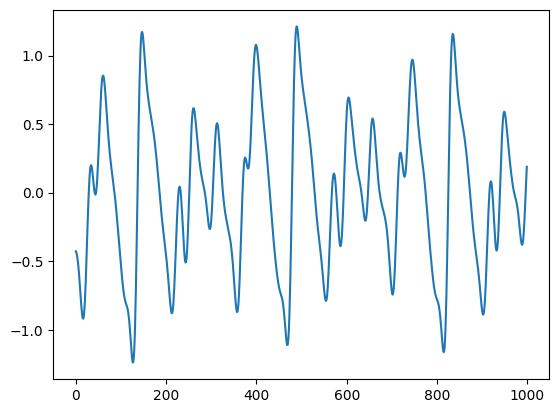

In [229]:
plt.plot(np.mean(np.real(ts_gap), axis=0))

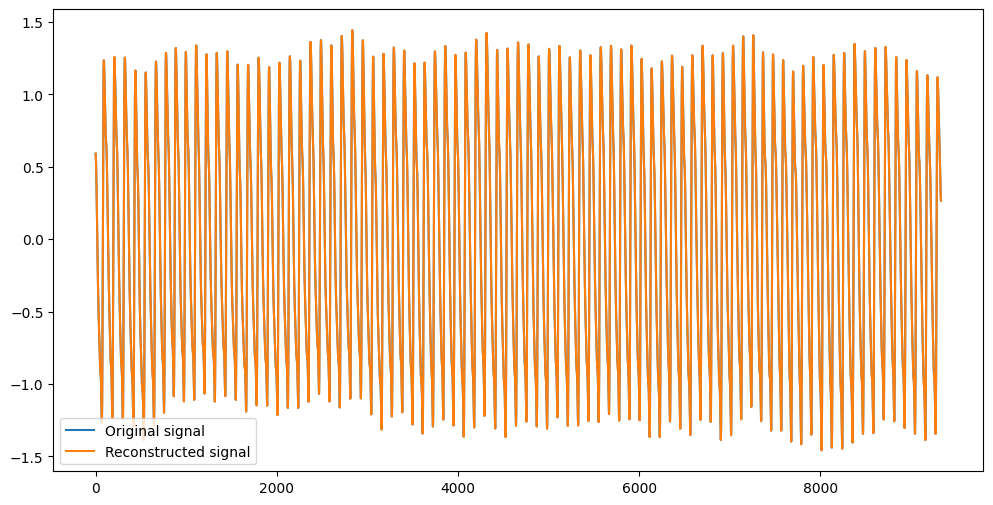

In [181]:
import pywt


signal = ts1_data[WavelengthIndex.RED]
signal2 = ts2_data[WavelengthIndex.RED]
# Decompose the signal into wavelets
coeffs = pywt.wavedec(signal, 'db1')
coeffs2 = pywt.wavedec(signal2, 'db1')

# Reconstruction
reconstructed_signal = pywt.waverec(coeffs, 'db1')

# Plot the original and reconstructed signal
plt.figure(figsize=(12, 6))
plt.plot(signal, label='Original signal')
plt.plot(reconstructed_signal, label='Reconstructed signal')
plt.legend()
plt.show()


In [352]:
time

array([0.000000e+00, 1.000000e-02, 2.000000e-02, ..., 2.906497e+04,
       2.906498e+04, 2.906499e+04])

In [366]:
Zxx_before

array([[-1.32090628e-02+0.00000000e+00j, -1.13634989e-02+0.00000000e+00j,
        -9.98969746e-03+0.00000000e+00j, ...,
        -3.50644812e-03+0.00000000e+00j, -1.27102435e-02+0.00000000e+00j,
        -1.35540294e-02+0.00000000e+00j],
       [ 5.42291740e-03-8.69687209e-04j,  1.10259991e-02+3.42959606e-03j,
        -3.09757222e-04-3.08875962e-03j, ...,
         3.51754150e-03-7.70444815e-03j,  5.66457364e-03-1.44192319e-03j,
         9.49166431e-03+7.18313962e-04j],
       [ 1.02862606e-02+6.95901037e-03j, -1.52823839e-03-2.40607258e-03j,
         1.73082851e-02-4.98671472e-03j, ...,
        -3.19454732e-03+1.10281060e-02j,  8.00505279e-03-4.51365556e-03j,
        -8.25893858e-03-4.40604985e-03j],
       ...,
       [ 1.10714371e-12-1.65378378e-13j,  3.50386498e-13+1.02775566e-14j,
        -3.98038935e-13+7.57482965e-14j, ...,
        -2.53847832e-13+1.94495087e-13j,  6.18058937e-12+1.41425982e-13j,
        -8.34150681e-06-1.43609967e-05j],
       [ 1.10713927e-12-8.26893554e-14j,  3.

In [42]:
gap_start

9000

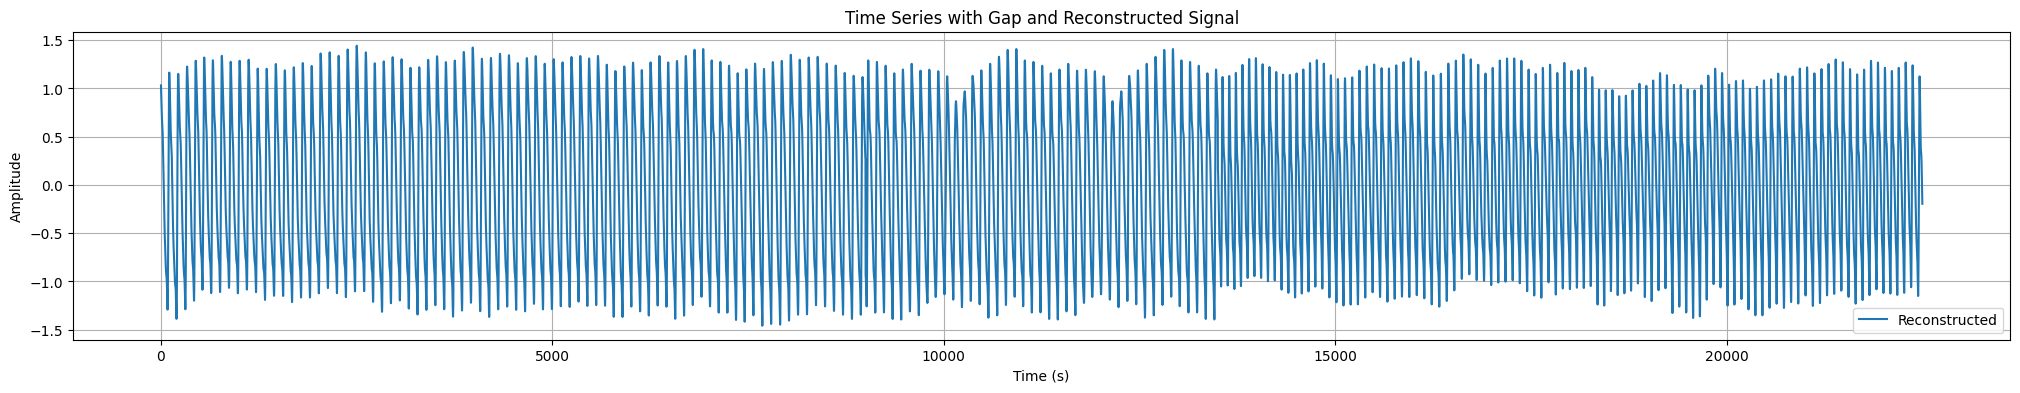

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, istft
from scipy.interpolate import interp1d
import pandas as pd


signal = ppg_data[WavelengthIndex.RED]
time = np.arange(0, len(signal)/1000, 0.01)


gap_start = np.where(np.isnan(signal))[0][0]
gap_end = np.where(np.isnan(signal))[0][-1] + 1
gap_length = gap_end - gap_start

gap_signal = np.copy(signal)
gap_signal[gap_start:gap_end] = np.nan

# Perform STFT before and after the gap
frequencies, times_before, Zxx_before = stft(gap_signal[:gap_start], fs=100, nperseg=4000, noverlap=3500, boundary=None)
_, times_after, Zxx_after = stft(gap_signal[gap_end:], fs=100, nperseg=4000, noverlap=3500, boundary=None)

# Initialize array to hold filled in spectral data
Zxx_fill = np.empty((len(frequencies), gap_end-gap_start), dtype=complex)

# Interpolate magnitude and phase for each frequency
for i in range(len(frequencies)):
    magnitude_before = np.abs(Zxx_before[i, -1])
    phase_before = np.angle(Zxx_before[i, -1])

    magnitude_after = np.abs(Zxx_after[i, 0])
    phase_after = np.angle(Zxx_after[i, 0])

    interp_mag = interp1d([times_before[-1], times_after[0]], [magnitude_before, magnitude_after], kind='linear', fill_value="extrapolate")
    interp_phase = interp1d([times_before[-1], times_after[0]], [phase_before, phase_after],  kind='linear', fill_value="extrapolate")

    Zxx_fill[i, :] = interp_mag(np.linspace(times_before[-1], times_after[0], gap_end-gap_start)) * np.exp(1j * interp_phase(np.linspace(times_before[-1], times_after[0], gap_end-gap_start)))

# Inverse STFT to fill the gap
_, gap_fill = istft(Zxx_fill, fs=100, time_axis=-1, freq_axis=-2)

# Ensure the filled signal is of correct length
gap_fill = gap_fill[:gap_end-gap_start]

# Reconstructing the full signal
reconstructed_signal = np.concatenate((gap_signal[:gap_start], gap_fill, gap_signal[gap_end:]))

# Plot the original signal with gap and the reconstructed signal
plt.figure(figsize=(25, 4))
# plt.plot(gap_signal, label='Original with Gap')
plt.plot(reconstructed_signal, label='Reconstructed')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time Series with Gap and Reconstructed Signal')
plt.grid(True)
plt.legend()
plt.show()

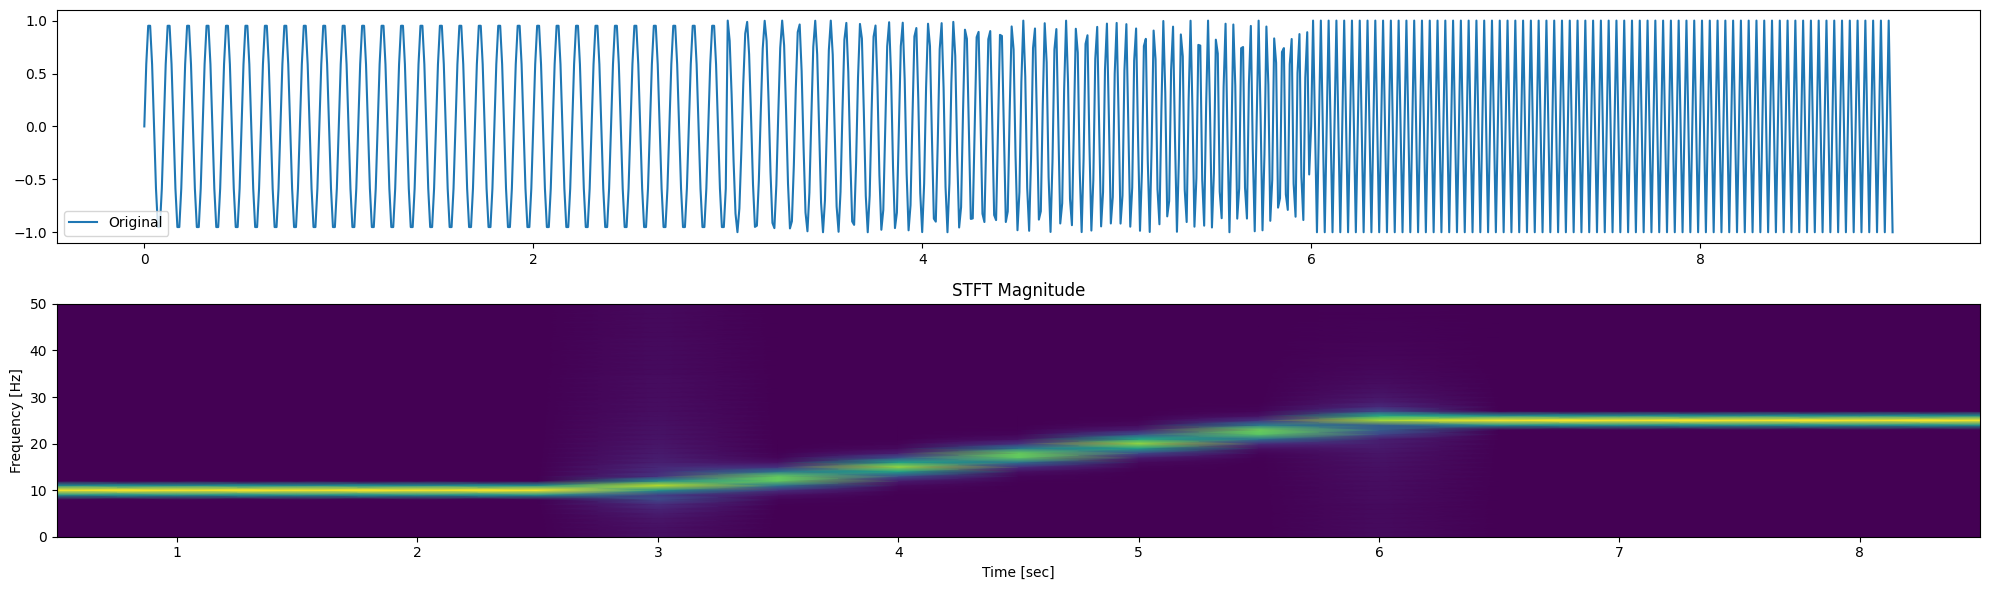

In [36]:
import numpy as np
from scipy.signal import stft, istft, chirp
import matplotlib.pyplot as plt

fs = 100  # Sampling frequency
T = 3  # seconds
t = np.arange(0, T, 1/fs)  # time variable
f1, f2 = 10, 25  # frequencies

x1 = np.sin(2*np.pi*f1*t)
x2 = np.sin(2*np.pi*f2*t)

t_gap = np.arange(0, len(t)/fs, 1/fs)  # time variable for gap
x_gap = chirp(t_gap, f0=f1, f1=f2, t1=t_gap[-1])

x = np.concatenate((x1, x_gap, x2))

plt.figure(figsize=(20, 6))
plt.subplot(2, 1, 1)
plt.plot(np.arange(0, len(x))/fs, x, label='Original')
plt.legend()

# Plot the STFT
plt.subplot(2, 1, 2)
f, t, Zxx = stft(x, fs, nperseg=100, noverlap=50, boundary=None)
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


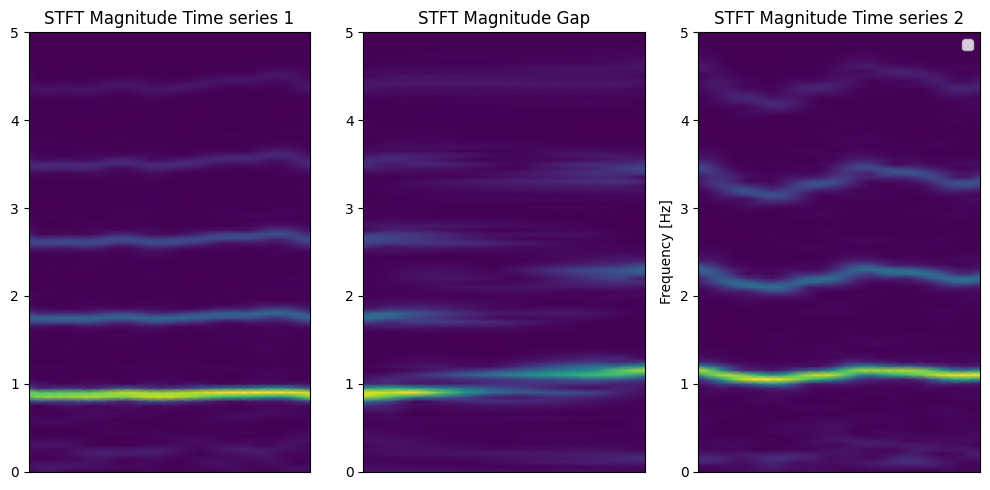

In [40]:
# frequencies, times_before, Zxx_before
# plt.figure(figsize=(20,10))
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,5))

ax[0].pcolormesh(times_before, frequencies, np.abs(Zxx_before), shading='gouraud')
ax[0].set_ylim([0, 5])
ax[0].title.set_text('STFT Magnitude Time series 1')

ax[1].pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
ax[1].set_ylim([0, 5])
ax[1].title.set_text('STFT Magnitude Gap')

ax[2].pcolormesh(times_after, frequencies, np.abs(Zxx_after), shading='gouraud')
ax[2].set_ylim([0, 5])
ax[2].title.set_text('STFT Magnitude Time series 2')
# plt.axvline(x=gap_start, label='gap_start', color='purple')
# plt.axvline(x=gap_end, label='gap_end')
# plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
# plt.xlabel('Timestep')
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
plt.tight_layout()
plt.legend()
plt.show()

In [302]:
from scipy.signal import correlate

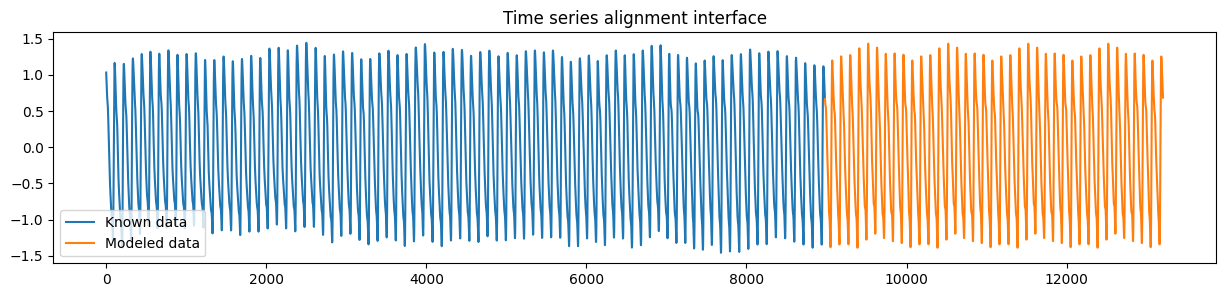

In [338]:
def compute_optimal_phase_shift(s1, s2):
    xcorr = correlate(s1, s2)
    shift = np.argmax(xcorr) - (len(s1) - 1)
    return int(shift)

def concatenate_with_shift(s1, s2):
    shift = compute_optimal_phase_shift(s1, s2)

    if shift < 0:
        s1 = s1[:shift]
    else:
        s2 = s2[shift:]

    threshold = max(s1)/100
    alignment_value = s2[0]

    fine_shift_index = 0
    for i, v in enumerate(reversed(s1)):
        if (alignment_value - threshold) <= v <= (alignment_value + threshold):
            fine_shift_index = i
            break

    return s1[:-fine_shift_index], s2

d1, d2 = concatenate_with_shift(signal[:gap_start], gap_fill)
plt.figure(figsize=(15,3))
#
# d1 = d1[8000:]
# d2 = d2[:1000]

plt.title('Time series alignment interface')
plt.plot(np.arange(0, len(d1), 1), d1, label='Known data')
plt.plot(np.arange(len(d1), len(d1) + len(d2), 1), d2, label='Modeled data')
plt.legend()

In [318]:
np.arange(0, len(d1), 1)

array([   0,    1,    2, ..., 8978, 8979, 8980])

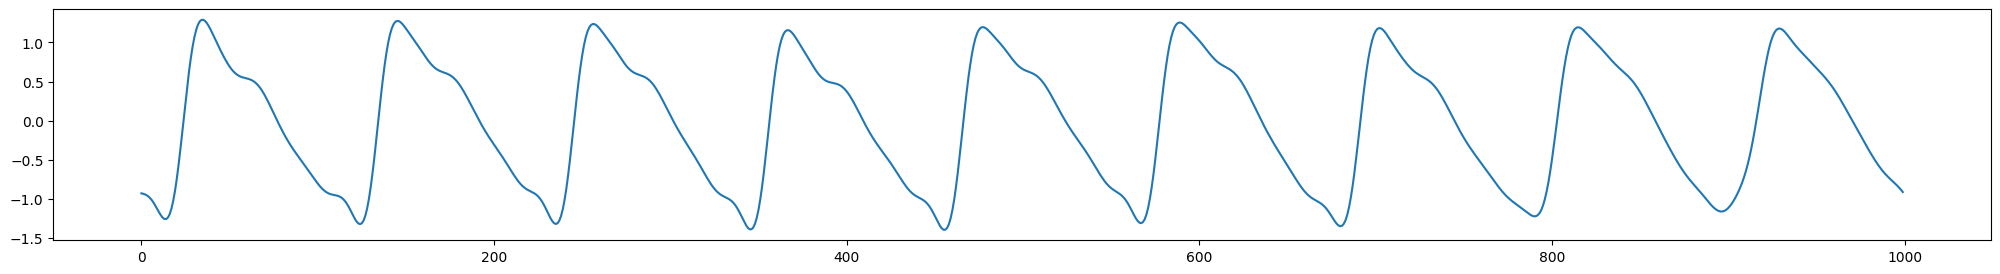

In [203]:
plt.figure(figsize=(25,3))
# plt.plot(match_phase(gap_signal[:gap_start], gap_fill))
plt.plot(gap_fill[:1000])

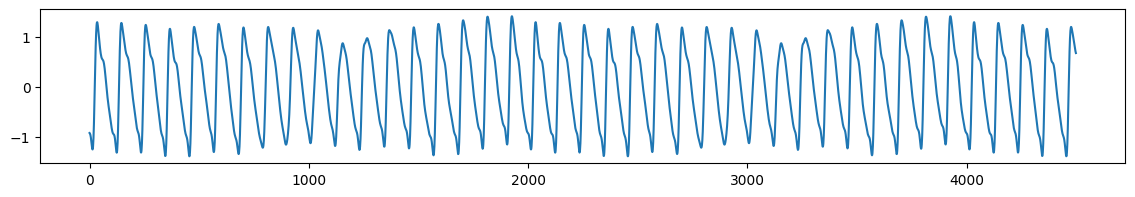

In [163]:
plt.figure(figsize=(14, 2))
plt.plot(gap_fill)

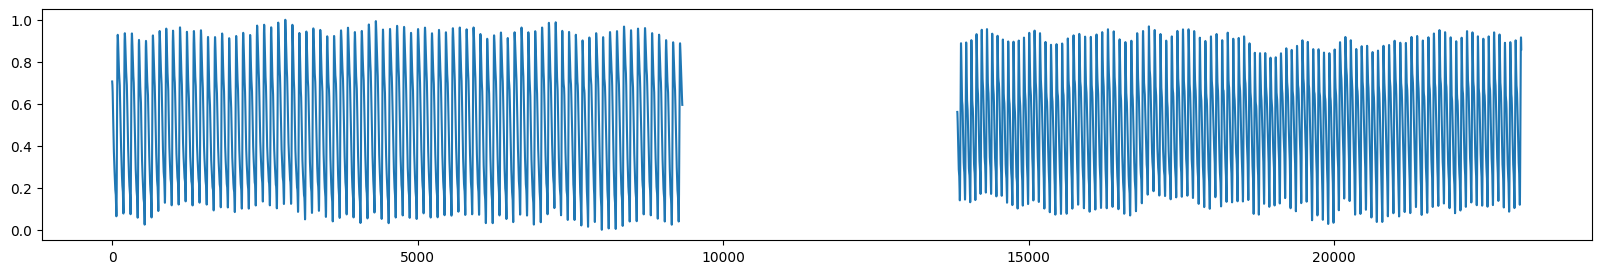

In [172]:
from sklearn.preprocessing import MinMaxScaler

scaled_signal = MinMaxScaler().fit_transform(signal.reshape(-1,1))

plt.figure(figsize=(20,3))
plt.plot(scaled_signal)

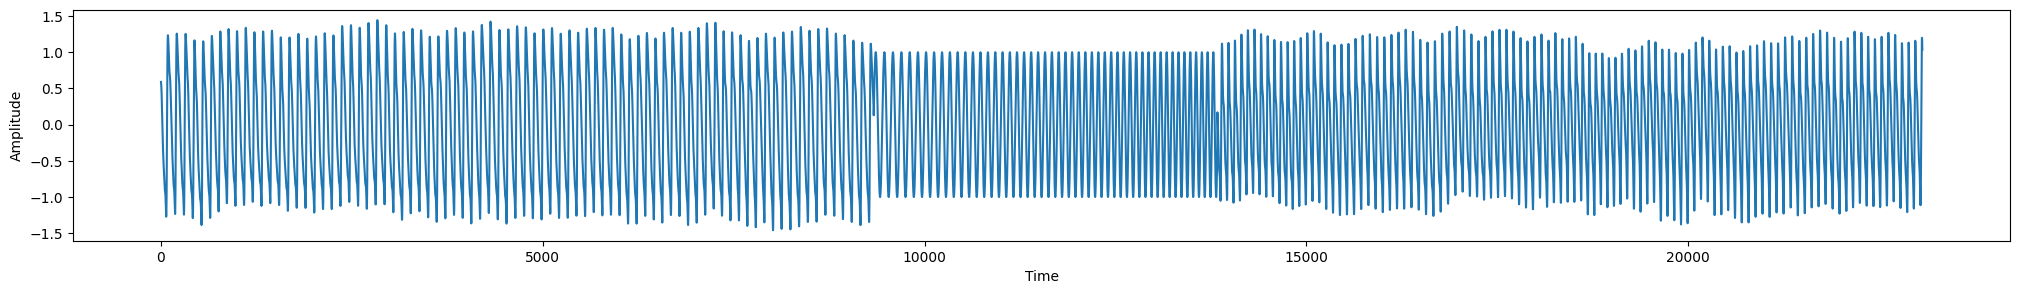

In [166]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

data_before_gap = signal[:gap_start]
data_after_gap = signal[gap_end:]
gap_size = gap_end - gap_start

fft_before = np.fft.fft(data_before_gap)
freq_before = np.fft.fftfreq(len(data_before_gap), 1/100)
main_freq_before = freq_before[np.argmax(np.abs(fft_before[:len(freq_before)//2]))]
main_phase_before = np.angle(fft_before[np.argmax(np.abs(fft_before[:len(freq_before)//2]))])

fft_after = np.fft.fft(data_after_gap)
freq_after = np.fft.fftfreq(len(data_after_gap), 1/100)
main_freq_after = freq_after[np.argmax(np.abs(fft_after[:len(freq_after)//2]))]
main_phase_after = np.angle(fft_after[np.argmax(np.abs(fft_after[:len(freq_after)//2]))])

time_gap = np.arange(gap_size) / 100  # divide by sample frequency to get time
freq_gap = np.linspace(main_freq_before, main_freq_after, gap_size)
phase_gap = np.linspace(main_phase_before, main_phase_after, gap_size)
# amplitude_gap = np.linspace(np.abs(data_before_gap[-1]), np.abs(data_after_gap[0]), gap_size)

# Generate the signal for the gap
gap_data = np.sin(2 * np.pi * freq_gap * time_gap + phase_gap)

# visualize the resulting time series
plt.figure(figsize=(25,3))
plt.plot(np.concatenate([data_before_gap, gap_data, data_after_gap]))
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()
